<a href="https://colab.research.google.com/github/dkswndms4782/BoostCamp_AI_Tech/blob/main/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/mlp.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/mlp.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Multilayer Perceptron (MLP)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.8.0+cu101].
device:[cuda:0].


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print("PyTorch versionL[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:[%s]."%(device))

PyTorch versionL[1.8.0+cu101].
device:[cuda:0].


### Dataset

In [ ]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

In [ ]:
import os
os.getcwd()

In [15]:
from torchvision import datasets, transforms
mnist_train = datasets.MNIST(root = './data/', train = True, transform = transforms.ToTensor(),download = True)
mnist_test = datasets.MNIST(root = './data/', train = False, transform = transforms.ToTensor(), download = True)
print("mnist_train:\n", mnist_train,"\n")
print("mnist_test:\n",mnist_test,"\n")
print('Done.')


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Data Iterator

Pytorch 의 DataLoader 는 배치 관리를 담당합니다. 여러분들은 모든 Dataset 으로부터 DataLoader 를 생성할 수 있습니다. DataLoader 는 배치들에 대해서 반복하기 쉽게 만들어줍니다. train_ds[i*bs : i*bs+bs] 를 사용하는 대신, DataLoader 는 매 미니배치를 자동적으로 제공합니다.

In [ ]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

In [37]:
size = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size = size, shuffle = True, num_workers = 1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size = size, shuffle = True, num_workers = 1)

### Define the MLP model

**nn.module을 사용하는 이유 : **

더 명확하고 간결한 훈련 루프를 위해 nn.Module 및 nn.Parameter 를 사용합니다. 우리는 nn.Module (자체가 클래스이고 상태를 추척할 수 있는) 하위 클래스(subclass)를 만듭니다. 이 경우에는, 포워드(forward) 단계에 대한 가중치, 절편, 그리고 메소드(method) 등을 유지하는 클래스를 만들고자 합니다. nn.Module 은 우리가 사용할 몇 가지 속성(attribute)과 메소드를 (.parameters() 와 .zero_grad() 같은) 가지고 있습니다.

https://tutorials.pytorch.kr/beginner/nn_tutorial.html

In [25]:
class MultiLayerPerceptronClass(nn.Module):
    """
        Multilayer Perceptron (MLP) Class
    """
    def __init__(self,name='mlp',xdim=784,hdim=256,ydim=10):
        super(MultiLayerPerceptronClass,self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdim = hdim
        self.ydim = ydim
        self.lin_1 = nn.Linear(
            self.xdim, self.hdim
        )
        self.lin_2 = nn.Linear(
            self.hdim, self.ydim
        )
        self.init_param() # initialize parameters
        
    def init_param(self):
        nn.init.kaiming_normal_(self.lin_1.weight) 
        nn.init.zeros_(self.lin_1.bias)
        nn.init.kaiming_normal_(self.lin_2.weight)
        nn.init.zeros_(self.lin_2.bias)

    def forward(self,x):
        net = x
        net = self.lin_1(net)
        net = F.relu(net)
        net = self.lin_2(net)
        return net.to('cuda')

M = MultiLayerPerceptronClass(name='mlp',xdim=784,hdim=256,ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(M.parameters(),lr=1e-3)
print ("Done.")

Done.


In [18]:
class MultiLayerPerceptronClass(nn.Module):
  def __init__(self, name = 'mlp', xdim = 784, hdim = 256, ydim = 10):
    super(MultiLayerPerceptronClass, self).__init__()
    self.name = name
    self.xdim = xdim
    self.hdim = hdim
    self.ydim = ydim
    self.lin_1 = nn.Linear(self.xdim,self.hdim)
    self.lin_2 = nn.Linear(self.hdim, self.ydim)
    self.init_param()

  def init_param(self):
    nn.init.kaiming_normal_(self.lin_1.weight) # weight를 초기화 하는거
    nn.init.zeros_(self.lin_1.bias)
    nn.init.kaiming_normal_(self.lin_2.weight)
    nn.init.zeros_(self.lin_2.bias)
  
  def forward(self, x):
    net = x
    net = self.lin_1(net)
    net = F.relu(net)
    net = self.lin_2(net)
    return net
  
M = MultiLayerPerceptronClass(name = 'mlp', xdim = 784, hdim = 256, ydim = 10)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(M.parameters(), lr = 1e-3)
print("Done.")

Done.


### Simple Forward Path of the MLP Model

In [ ]:
x_numpy = np.random.rand(2,784)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = M.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
print ("x_numpy:\n",x_numpy)
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("y_numpy:\n",y_numpy)

In [26]:
x_numpy = np.random.rand(2,784)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = M.forward(x_torch)
y_numpy = y_torch.detach().cpu().numpy()

### Check Parameters

In [ ]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(M.named_parameters()):
    param_numpy = param.detach().cpu().numpy()
    n_param += len(param_numpy.reshape(-1))
    print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
    print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

In [33]:
np.set_printoptions(precision = 3)
n_param = 0
for p_idx,(param_name, param) in enumerate(M.named_parameters()):
  param_numpy = param.detach().cpu().numpy()
  n_param += len(param_numpy.reshape(-1))
  print("[%d] name:[%s] shape:[%s]."%(p_idx, param_name, param_numpy.shape))
  print("   val:%s"%(param_numpy.reshape(-1)[:5]))
print("Total number of parameters:[%s]." %(format(n_param, ",d")))
# format은 왜 붙이는거고 ,d는 뭐야? --> [203530]을 [203, 530으로 해줘]

[0] name:[lin_1.weight] shape:[(256, 784)].
   val:[ 0.016  0.015  0.005 -0.021 -0.124]
[1] name:[lin_1.bias] shape:[(256,)].
   val:[0. 0. 0. 0. 0.]
[2] name:[lin_2.weight] shape:[(10, 256)].
   val:[-0.141 -0.027  0.03  -0.234  0.174]
[3] name:[lin_2.bias] shape:[(10,)].
   val:[0. 0. 0. 0. 0.]
Total number of parameters:[203,530].


### Evaluation Function

In [ ]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        model.eval() # evaluate (affects DropOut and BN)
        n_total,n_correct = 0,0
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(
                batch_in.view(-1,28*28).to(device)
            )
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (
                y_pred == y_trgt
            ).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

In [67]:
def func_eval(model, data_iter, device):
  with torch.no_grad():
    model.eval()
    n_total, n_correct = 0,0
    for batch_in, batch_out in data_iter:
      y_trgt = batch_out.to(device)
      model_pred = model(batch_in.view(-1, 28*28).to(device)) 
      # forward로 넣는게 아니라 model()에 바로 넣는데 가능?
      # --> forward하는거랑 안하는거랑 같은데 그 비슷한 과제가 있었지 않나? 피어세션 게시판? 움움

      _, y_pred = torch.max(model_pred.data,1) 
      # 왜 max랑 1을 넣지? 밑에서는 argmax였는데            
      # y_pred의 값은 뭘로 출력이 되는 걸까? model_pred는?
      # --> torch.max(t7, dim=1) == 행방향으로 최대값 구해라 return값 (value, index)

      n_correct += (y_pred == y_trgt).sum().item() 
      # 왜 sum을 하고 item을 해줄까?
      # (y_pred == y_trgt).sum() == tensor(20, device='cuda:0')
      # (y_pred == y_trgt).sum().item() == 20
      
      n_total += batch_in.size(0)
    val_accr = (n_correct/n_total)
    model.train()
  return val_accr
print("Done.")

Done.


### Initial Evaluation

In [ ]:
M.init_param() # initialize parameters
train_accr = func_eval(M,train_iter,device)
test_accr = func_eval(M,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

In [ ]:
M.init_param()
train_accr = func_eval(M, train_iter, device)
test_accr = func_eval(M, test_iter, device)
print("train_accr:[%.3f] test_accr:[%.3f]"%(train_accr, test_accr))

### Train

In [ ]:
print ("Start training.")
M.init_param() # initialize parameters
M.train()
EPOCHS,print_every = 10,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = M.forward(batch_in.view(-1, 28*28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad()      # reset gradient 
        loss_out.backward()      # backpropagate
        optm.step()      # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(M,train_iter,device)
        test_accr = func_eval(M,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")        

In [ ]:
print("start training.")
M.init_param()
M.train()
EPOCHS, print_every = 10, 1
for eposh in range(EPOCHS):
  loss_val_sum = 0
  for batch_in, batch_out in train_iter:
    # Forward path
    y_pred = M.forward(batch_in.view(-1,28*28).to(device))
    loss_out = loss(y_pred, batch_out.to(device))
    # Update
    #  매개변수를 수동으로 업데이트 하는 대신, 옵티마이저(optimizer)의 step 메소드를 사용하여 업데이트를 진행할 수 있습니다.
    optm.zero_grad() # reset gradient 
    loss_out.backward()  # backpropagate
    optm.step()  # optimizer update
    loss_val_sum += loss_out
  loss_val_avg = loss_val_sum/len(train_iter)
  # Print
  if ((epoch%print_every) == 0) or (epoch == (EPOCHS -1)):
    train_accr = func_eval(M, train_iter, device)
    test_accr = func_eval(M, test_iter, device)
    print(f"epoch: {epoch} loss: {loss_val_avg} train_accr:{train_accr} test_accr:{test_accr}")
  print("Done.")

### Test

In [ ]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    y_pred = M.forward(test_x.view(-1, 28*28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print ("Done")

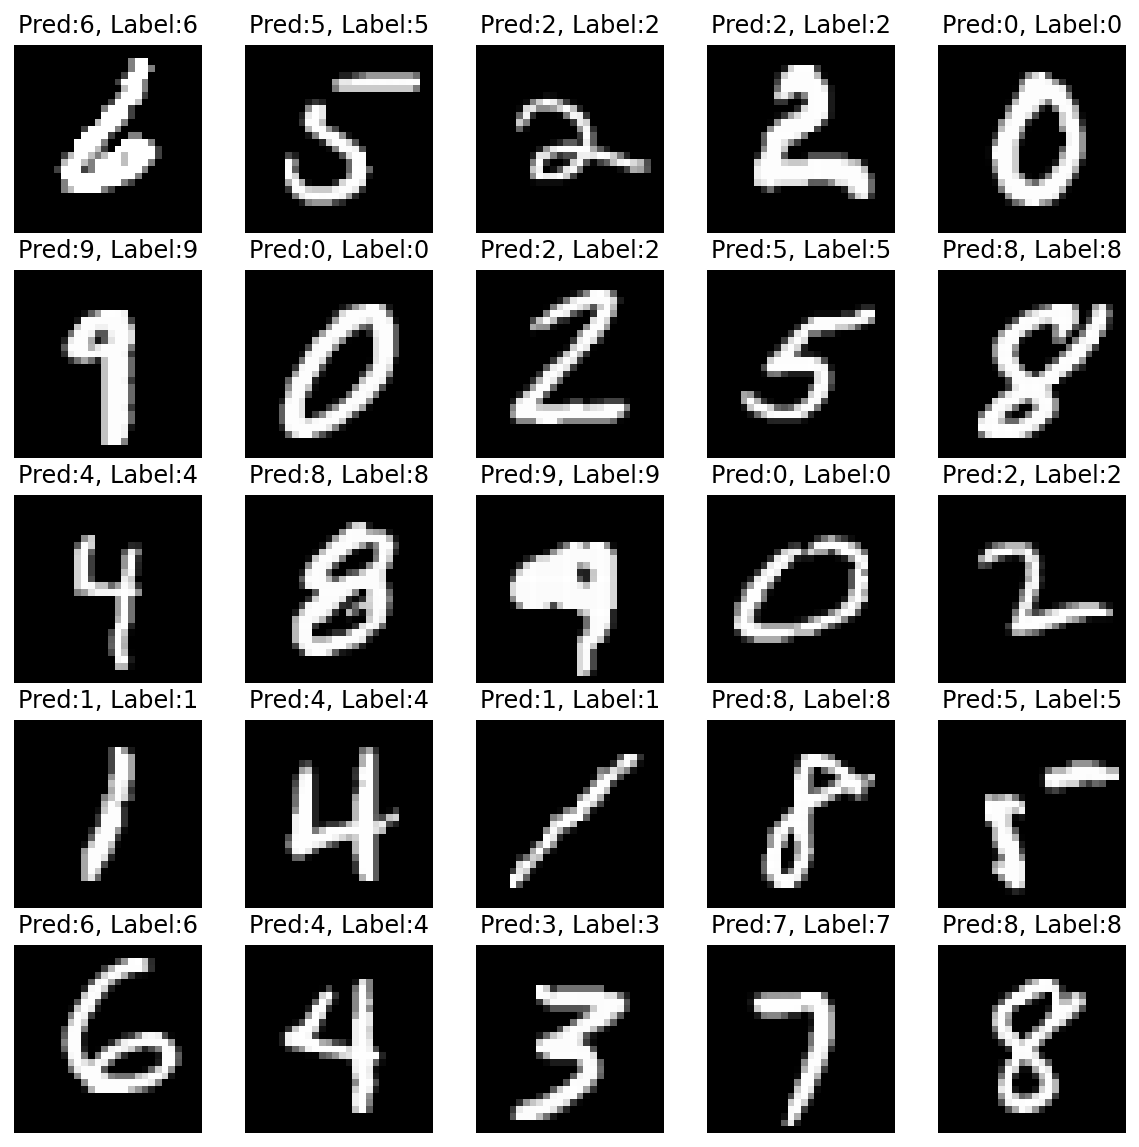

Done


In [92]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace = False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
  y_pred = M.forward(test_x.view(-1, 28*28).type(torch.float).to(device)/255.)
  # ????/255.
  # --> mnist_test를 DataRoader를 거치면 바로 사용 가능(type(torch.float)없이)
  # --> 근데 mnist_test는 Dataset으로 불러온 데이터셋 그 자체
  # --> 그래서 float형으로 변환시켜줘야함. 
  # --> 255로 나눈 이유는 값이 너무 커서인것같음. 값은 1000도 나오고 그럼. 나눈 후에도 4.~~ 5.~~이렇게 나옴 특정 범위를 지정해주려고 했다기보다는 커서 그런거 아닐까
  # --> 다만 픽셀크기가 RGB일때는 256인가 그럼. 그래서 255로 나눠준거 아닐까? 255라는 숫자는 픽셀이랑 관련 있을듯.
  # --> 255로 나눈거랑 255.으로 나눈거랑 값은 같음. 다만 원래값에 소수점이 있어서 소수점 붙여서 나눠준게 아닐까 싶음.
  # --> argmax로 제일 큰 값의 index를 뽑음. 그래서 255로 안나눠줘도 결과는 같음.

y_pred = y_pred.argmax(axis = 1)
plt.figure(figsize = (10,10))
for idx in range(n_sample):
  plt.subplot(5,5, idx + 1)
  plt.imshow(test_x[idx], cmap = 'gray')
  plt.axis("off")
  plt.title(f"Pred:{y_pred[idx]}, Label:{test_y[idx]}")
plt.show()
print("Done")